In [ ]:
import pickle
from glob import glob
from tqdm import tqdm
import statistics
import os

category_analysis = False

all_datafiles = []
# level = "easy" # "easy" or "medium"
# heuristic = "random_sampling" # "no_heuristic" or "goal_proximity" or "single_stream" or "ml_both" or "goal_ml" or "goal_ml_mse_dice_eps"
# # heuristic = "random_sampling"# "goal_ml_mse_dice_eps_1_mix_eps20" "goal_ml_mse_dice_eps_1_mix_eps0" # "no_heuristic" or "goal_proximity" or "single_stream" or "ml_both" or "goal_ml" or "goal_ml_mse_dice_eps"
# DATA_DIR = f"/common/users/dm1487/namo_data/idfs_test_set/aug31/{level}/{heuristic}"
# all_datafiles += list(glob(f"{DATA_DIR}/*/*.pkl"))

# level = "medium" # "easy" or "medium"
# # heuristic = "goal_proximity_eps_10" # "no_heuristic" or "goal_proximity" or "single_stream" or "ml_both" or "goal_ml" or "goal_ml_mse_dice_eps"
# # heuristic = "goal_ml_mse_dice_eps_1_mix_eps50" # "no_heuristic" or "goal_proximity" or "single_stream" or "ml_both" or "goal_ml" or "goal_ml_mse_dice_eps"
# heuristic = "random_sampling"# "goal_ml_mse_dice_eps_1_mix_eps20" "goal_ml_mse_dice_eps_1_mix_eps0" # "no_heuristic" or "goal_proximity" or "single_stream" or "ml_both" or "goal_ml" or "goal_ml_mse_dice_eps"
# DATA_DIR = f"/common/users/dm1487/namo_data/idfs_test_set/aug31/{level}/{heuristic}"
# all_datafiles += list(glob(f"{DATA_DIR}/*/*.pkl"))

# sep6/hard_very_hard/cross_atn_goal_ml_mse_dice_eps_1_ep_00
# very_hard/cross_atn_dt_goal_ml_mse_dice_eps_1_mix_eps0
level = "medium" # "easy" or "medium"
# heuristic = "cross_atn_dt_goal_ml_mse_dice_eps_1_ep_00" # "cross_atn_goal_ml_mse_dice_eps_1_ep_00" # "no_heuristic" or "goal_proximity" or "single_stream" or "ml_both" or "goal_ml" or "goal_ml_mse_dice_eps"
heuristic = "no_heuristic" # "cross_atn_goal_ml_mse_dice_eps_1_ep_00" # "no_heuristic" or "goal_proximity" or "single_stream" or "ml_both" or "goal_ml" or "goal_ml_mse_dice_eps"
# heuristic = "random_sampling"# "goal_ml_mse_dice_eps_1_mix_eps20" "goal_ml_mse_dice_eps_1_mix_eps0" # "no_heuristic" or "goal_proximity" or "single_stream" or "ml_both" or "goal_ml" or "goal_ml_mse_dice_eps"
DATA_DIR = f"/common/users/dm1487/namo_data/idfs_train_set/sep12/{level}/{heuristic}"
all_datafiles += list(glob(f"{DATA_DIR}/*/*.pkl"))

# DATA_DIR = "../test_ml"
# Focus only on episodes requiring manipulation
manipulation_episodes = 0
successful_manipulations = 0
timeout_episodes = 0
crashed_episodes = 0

solution_depths = []
nodes_expanded = []
terminal_checks = []
search_times = []

# Track trivial solution environments
trivial_solution_environments = []

# Track environment performance
environment_performance = {}

# Track processed XML files to avoid duplicates
processed_xml_files = set()

# Add new tracking variables for failures
failure_analysis = {
    'failure_codes': {},
    'error_messages': {},
    'failed_episodes': []
}

# Track environments with at least one solution
environments_with_solutions = set()

# all_datafiles = list(glob(f"{DATA_DIR}/*/*.pkl")) + list(glob(f"{DATA_DIR}/*/*.pkl"))
print(len(all_datafiles))
count_all_dp = 0
for file in tqdm(all_datafiles):
    if "env" in file:
        with open(file, "rb") as f:
            data = pickle.load(f)
            if "episode_results" not in data:
                continue
            sequence_lengths = []
            
            for ep_idx, episode_result in enumerate(data['episode_results'][:10]):
                episode_success = episode_result.get('success', True)
                solution_found = episode_result.get('solution_found', False)
                action_sequence = episode_result.get('action_sequence')
                state_observations = episode_result.get('state_observations')
                
                solution_depth = episode_result.get('solution_depth', 0)
                xml_file = episode_result.get('xml_file', 'unknown')
                
                # Extract error information
                error_message = episode_result.get('error_message', '')
                failure_code = episode_result.get('failure_code', None)
                
                # Extract filename with 2 parent folders
                if xml_file != 'unknown' and '/' in xml_file:
                    path_parts = xml_file.split('/')
                    if len(path_parts) >= 4:
                        xml_filename = '/'.join(path_parts[-4:])  # Take last 3 parts (2 parent folders + filename)
                    else:
                        xml_filename = xml_file
                else:
                    xml_filename = xml_file
                    
                # xml_filename = xml_file
                
                # Skip if we've already processed this XML file
                
                if xml_filename in processed_xml_files and ep_idx == 0:
                    # print("skipping", xml_filename)
                    continue
                # Mark this XML file as processed
                processed_xml_files.add(xml_filename)
                
                # Initialize environment tracking
                if xml_filename not in environment_performance:
                    environment_performance[xml_filename] = {
                        'total_episodes': 0,
                        'successful_episodes': 0,
                        'timeout_episodes': 0,
                        'crashed_episodes': 0,
                        'trivial_episodes': 0,
                        'search_times': [],
                        'nodes_expanded': [],
                        'terminal_checks': [],
                        'solution_depths': []
                    }
                
                env_stats = environment_performance[xml_filename]
                
                # Check for trivial solutions and record them
                if solution_found and (solution_depth == 0 or not action_sequence):
                    trivial_solution_environments.append({
                        'xml_file': xml_file,
                        'solution_depth': solution_depth,
                        'action_sequence': action_sequence,
                        'episode_id': episode_result.get('episode_id', 'unknown')
                    })
                    env_stats['trivial_episodes'] += 1
                    
                    continue
                
                # Skip episodes that didn't complete successfully
                if not episode_success:
                    crashed_episodes += 1
                    env_stats['crashed_episodes'] += 1
                    
                    # Collect failure information
                    failure_info = {
                        'xml_file': xml_filename,
                        'episode_id': episode_result.get('episode_id', 'unknown'),
                        'error_message': error_message,
                        'failure_code': failure_code,
                        'solution_found': solution_found,
                        'nodes_expanded': episode_result.get('nodes_expanded', 0),
                        'terminal_checks': episode_result.get('terminal_checks', 0),
                        'search_time_ms': episode_result.get('search_time_ms', 0)
                    }
                    
                    failure_analysis['failed_episodes'].append(failure_info)
                    # env_stats['failed_episodes'].append(failure_info)
                    
                    # Count failure codes
                    if failure_code is not None:
                        failure_analysis['failure_codes'][failure_code] = failure_analysis['failure_codes'].get(failure_code, 0) + 1
                    
                    # Count error messages (truncate long messages)
                    error_key = error_message[:100] + "..." if len(error_message) > 100 else error_message
                    if error_message:
                        failure_analysis['error_messages'][error_key] = failure_analysis['error_messages'].get(error_key, 0) + 1
                    
                    
                    continue
                
                # Count this as a manipulation episode
                manipulation_episodes += 1
                env_stats['total_episodes'] += 1
                
                if solution_found and action_sequence:
                    # Successfully found solution requiring manipulation
                    successful_manipulations += 1
                    env_stats['successful_episodes'] += 1
                    
                    # Mark this environment as having at least one solution
                    environments_with_solutions.add(xml_filename)
                    
                    # Collect detailed statistics
                    solution_depths.append(episode_result['solution_depth'])
                    nodes_expanded.append(episode_result['nodes_expanded'])
                    terminal_checks.append(episode_result['terminal_checks'])
                    search_times.append(episode_result.get('search_time_ms', 0))
                    sequence_lengths.append(len(action_sequence))
                    
                    # Collect environment-specific stats
                    env_stats['solution_depths'].append(episode_result['solution_depth'])
                    env_stats['search_times'].append(episode_result.get('search_time_ms', 0))
                    env_stats['nodes_expanded'].append(episode_result['nodes_expanded'])
                    env_stats['terminal_checks'].append(episode_result['terminal_checks'])
                    
                else:
                    # No solution found (timeout/limits)
                    timeout_episodes += 1
                    env_stats['timeout_episodes'] += 1
                    
                    # Still collect search effort stats
                    nodes_expanded.append(episode_result['nodes_expanded'])
                    terminal_checks.append(episode_result['terminal_checks'])
                    search_times.append(episode_result.get('search_time_ms', 0))
                    
                    # Collect environment-specific stats
                    env_stats['search_times'].append(episode_result.get('search_time_ms', 0))
                    env_stats['nodes_expanded'].append(episode_result['nodes_expanded'])
                    env_stats['terminal_checks'].append(episode_result['terminal_checks'])
                    
            if len(sequence_lengths) > 0:
                min_seq_length = min(sequence_lengths)
                for seq_length in sequence_lengths:
                    if seq_length == min_seq_length:
                        count_all_dp += 1
print(count_all_dp)
# Get unique trivial solution environments
unique_trivial_environments = {}
for env in trivial_solution_environments:
    # Extract filename with 2 parent folders for trivial environments too
    xml_file = env['xml_file']
    if xml_file != 'unknown' and '/' in xml_file:
        path_parts = xml_file.split('/')
        if len(path_parts) >= 3:
            xml_filename = '/'.join(path_parts[-3:])  # Take last 3 parts (2 parent folders + filename)
        else:
            xml_filename = xml_file
    else:
        xml_filename = xml_file
    
    if xml_filename not in unique_trivial_environments:
        unique_trivial_environments[xml_filename] = {
            'count': 0,
            'solution_depths': [],
            'has_actions': []
        }
    unique_trivial_environments[xml_filename]['count'] += 1
    unique_trivial_environments[xml_filename]['solution_depths'].append(env['solution_depth'])
    unique_trivial_environments[xml_filename]['has_actions'].append(env['action_sequence'] is not None)

# Print unique trivial solution environments
# print(f"=== UNIQUE TRIVIAL SOLUTION ENVIRONMENTS ===")
# print(f"Found {len(unique_trivial_environments)} unique environments with trivial solutions:")
# for xml_filename in sorted(unique_trivial_environments.keys()):
#     env_data = unique_trivial_environments[xml_filename]
#     depths = set(env_data['solution_depths'])
#     has_actions = set(env_data['has_actions'])
#     print(f"  {xml_filename} - count: {env_data['count']}, depths: {sorted(depths)}, has_actions: {sorted(has_actions)}")

# Calculate success rate for meaningful episodes only
success_rate = successful_manipulations / manipulation_episodes if manipulation_episodes > 0 else 0
timeout_rate = timeout_episodes / manipulation_episodes if manipulation_episodes > 0 else 0

print(f"\n=== MANIPULATION-ONLY EPISODE ANALYSIS ===")
print(f"(Ignoring zero-step solutions)")
print(f"")
print(f"Total manipulation episodes: {manipulation_episodes}")
print(f"├── Successful: {successful_manipulations}")
print(f"└── Timed out: {timeout_episodes}")
print(f"")
print(f"Success rate: {success_rate:.3f} ({successful_manipulations}/{manipulation_episodes})")
print(f"Timeout rate: {timeout_rate:.3f} ({timeout_episodes}/{manipulation_episodes})")

if solution_depths:
    print(f"\n=== SUCCESSFUL EPISODE STATISTICS ===")
    print(f"Solution depth:")
    print(f"  Average: {statistics.mean(solution_depths):.2f}")
    print(f"  Median: {statistics.median(solution_depths):.2f}")
    print(f"  Range: {min(solution_depths)} - {max(solution_depths)}")
    
    # Solution depth distribution
    depth_counts = {}
    for depth in solution_depths:
        depth_counts[depth] = depth_counts.get(depth, 0) + 1
    print(f"  Distribution:")
    for depth in sorted(depth_counts.keys()):
        percentage = depth_counts[depth] / len(solution_depths) * 100
        print(f"    {depth} steps: {depth_counts[depth]} episodes ({percentage:.1f}%)")

if nodes_expanded:
    print(f"\nSearch effort (all manipulation episodes):")
    print(f"  Nodes expanded - Average: {statistics.mean(nodes_expanded):.0f}")
    print(f"  Nodes expanded - Median: {statistics.median(nodes_expanded):.0f}")
    print(f"  Nodes expanded - Max: {max(nodes_expanded)}")
    
if terminal_checks:
    print(f"  Terminal checks - Average: {statistics.mean(terminal_checks):.0f}")
    print(f"  Terminal checks - Median: {statistics.median(terminal_checks):.0f}")
    print(f"  Terminal checks - Max: {max(terminal_checks)}")

if search_times:
    # Convert to seconds
    search_times_sec = [t/1000 for t in search_times if t > 0]
    if search_times_sec:
        print(f"  Search time - Average: {statistics.mean(search_times_sec):.2f}s")
        print(f"  Search time - Median: {statistics.median(search_times_sec):.2f}s")
        print(f"  Search time - Max: {max(search_times_sec):.2f}s")

print(f"\nEpisodes analyzed: {len(solution_depths)} successful + {timeout_episodes} timeouts = {manipulation_episodes} total")
print(f"Crashed episodes (excluded): {crashed_episodes}")
print(f"Trivial solution episodes (excluded): {len(trivial_solution_environments)}")


if category_analysis:
    # Categorize environments by difficulty based on success rate
    difficulty_categories = {
        'very_easy': [],    # 100% success
        'easy': [],         # 75-99.9% success  
        'medium': [],       # 25-75% success
        'hard': [],         # 0.1-25% success
        'very_hard': []     # 0% success
    }

    for xml_filename, stats in environment_performance.items():
        if stats['total_episodes'] > 0:
            success_rate = stats['successful_episodes'] / stats['total_episodes']
            
            if success_rate == 1.0:
                difficulty_categories['very_easy'].append(xml_filename)
            elif success_rate >= 0.75:
                difficulty_categories['easy'].append(xml_filename)
            elif success_rate >= 0.25:
                difficulty_categories['medium'].append(xml_filename)
            elif success_rate > 0.0:
                difficulty_categories['hard'].append(xml_filename)
            else:
                difficulty_categories['very_hard'].append(xml_filename)

    print(f"\n=== ENVIRONMENT DIFFICULTY CATEGORIZATION ===")
    print(f"Very Easy (100% success): {len(difficulty_categories['very_easy'])} environments")
    print(f"Easy (75-99.9% success): {len(difficulty_categories['easy'])} environments")
    print(f"Medium (25-75% success): {len(difficulty_categories['medium'])} environments")
    print(f"Hard (0.1-25% success): {len(difficulty_categories['hard'])} environments")
    print(f"Very Hard (0% success): {len(difficulty_categories['very_hard'])} environments")

    # Find environments with less than 50% success rate
    low_success_environments = []
    for xml_filename, stats in environment_performance.items():
        if stats['total_episodes'] > 0:
            success_rate = stats['successful_episodes'] / stats['total_episodes']
            if success_rate <= 0.5:
                low_success_environments.append({
                    'xml_filename': xml_filename,
                    'success_rate': success_rate,
                    'total_episodes': stats['total_episodes'],
                    'successful_episodes': stats['successful_episodes'],
                    'timeout_episodes': stats['timeout_episodes']
                })

    print(f"\n=== ENVIRONMENTS WITH ≤50% SUCCESS RATE ===")
    print(f"Found {len(low_success_environments)} environments with ≤50% success rate")

# Find top 10 worst performing environments
# print(f"\n=== TOP 10 WORST PERFORMING ENVIRONMENTS ===")
worst_environments = []
for xml_filename, stats in environment_performance.items():
    if stats['total_episodes'] > 0:
        success_rate = stats['successful_episodes'] / stats['total_episodes']
        avg_search_time = statistics.mean(stats['search_times']) if stats['search_times'] else 0
        avg_nodes_expanded = statistics.mean(stats['nodes_expanded']) if stats['nodes_expanded'] else 0
        avg_terminal_checks = statistics.mean(stats['terminal_checks']) if stats['terminal_checks'] else 0
        solution_depth = statistics.mean(stats['solution_depths']) if stats['solution_depths'] else 0
        worst_environments.append({
            'xml_filename': xml_filename,
            'success_rate': success_rate,
            'total_episodes': stats['total_episodes'],
            'successful_episodes': stats['successful_episodes'],
            'timeout_episodes': stats['timeout_episodes'],
            'avg_search_time_ms': avg_search_time,
            'avg_nodes_expanded': avg_nodes_expanded,
            'avg_terminal_checks': avg_terminal_checks,
            'avg_solution_depth': solution_depth
        })

# Sort by success rate (ascending) then by average search time (descending)
worst_environments.sort(key=lambda x: (x['success_rate'], -x['avg_search_time_ms']))

print(f"Showing worst 10 environments by success rate and search time:")
for i, env in enumerate(worst_environments[:10], 1):
    print(f"{i:2d}. {env['xml_filename']}")
    print(f"     Success rate: {env['success_rate']:.3f} ({env['successful_episodes']}/{env['total_episodes']})")
    print(f"     Avg search time: {env['avg_search_time_ms']/1000:.2f}s")
    print(f"     Avg nodes expanded: {env['avg_nodes_expanded']:.0f}")
    print(f"     Avg terminal checks: {env['avg_terminal_checks']:.0f}")
    print()
# Verify our counting
assert successful_manipulations + timeout_episodes == manipulation_episodes

['/common/users/dm1487/namo_data/idfs_train_set/sep12/medium/no_heuristic/modular_data_ilab1/ilab1_env_000013_results.pkl', '/common/users/dm1487/namo_data/idfs_train_set/sep12/medium/no_heuristic/modular_data_ilab1/ilab1_env_000003_results.pkl', '/common/users/dm1487/namo_data/idfs_train_set/sep12/medium/no_heuristic/modular_data_ilab1/ilab1_env_000001_results.pkl', '/common/users/dm1487/namo_data/idfs_train_set/sep12/medium/no_heuristic/modular_data_ilab1/ilab1_env_000011_results.pkl', '/common/users/dm1487/namo_data/idfs_train_set/sep12/medium/no_heuristic/modular_data_ilab1/ilab1_env_000014_smoothed_results.pkl', '/common/users/dm1487/namo_data/idfs_train_set/sep12/medium/no_heuristic/modular_data_ilab1/ilab1_env_000005_smoothed_results.pkl', '/common/users/dm1487/namo_data/idfs_train_set/sep12/medium/no_heuristic/modular_data_ilab1/ilab1_env_000018_smoothed_results.pkl', '/common/users/dm1487/namo_data/idfs_train_set/sep12/medium/no_heuristic/modular_data_ilab1/ilab1_env_000017_re

100%|██████████| 26/26 [00:00<00:00, 2045.58it/s]

5

=== MANIPULATION-ONLY EPISODE ANALYSIS ===
(Ignoring zero-step solutions)

Total manipulation episodes: 20
├── Successful: 5
└── Timed out: 15

Success rate: 0.250 (5/20)
Timeout rate: 0.750 (15/20)

=== SUCCESSFUL EPISODE STATISTICS ===
Solution depth:
  Average: 4.80
  Median: 5.00
  Range: 4 - 5
  Distribution:
    4 steps: 1 episodes (20.0%)
    5 steps: 4 episodes (80.0%)

Search effort (all manipulation episodes):
  Nodes expanded - Average: 1217
  Nodes expanded - Median: 1101
  Nodes expanded - Max: 2800
  Terminal checks - Average: 1218
  Terminal checks - Median: 1102
  Terminal checks - Max: 2801
  Search time - Average: 1587.20s
  Search time - Median: 1800.60s
  Search time - Max: 1803.04s

Episodes analyzed: 5 successful + 15 timeouts = 20 total
Crashed episodes (excluded): 0
Trivial solution episodes (excluded): 0
Showing worst 10 environments by success rate and search time:
 1. medium/set1/benchmark_1/env_config_1075d.xml
     Success rate: 0.000 (0/1)
     Avg sear

In [28]:
# goal_prox_environments_with_solutions = environments_with_solutions.copy()
no_heuristic_environments_with_solutions = environments_with_solutions.copy()

In [33]:
len(goal_prox_environments_with_solutions), len(no_heuristic_environments_with_solutions), len(goal_prox_environments_with_solutions.union(no_heuristic_environments_with_solutions))


(746, 129, 875)

In [77]:
unsolved_envs = []
for env in worst_environments:
    if env['successful_episodes'] == 0:
        unsolved_envs.append(env['xml_filename'])
unsolved_envs

['medium/set1/benchmark_1/env_config_1561c.xml']

In [79]:
# len(unsolved_envs)
# with open('unsolved_envs.pkl', 'wb') as f:
#     pickle.dump(unsolved_envs, f)

In [5]:
worst_envs_goal_prox = worst_environments.copy()
# worst_envs_ml = worst_environments.copy()
# worst_envs_random_sampling = worst_environments.copy()
# worst_envs_no_heuristic = worst_environments.copy()
# worst_envs_ml
# len(worst_envs_goal_prox), len(worst_envs_ml), len(worst_envs_random_sampling)

In [6]:
worst_envs_goal_prox

[{'xml_filename': 'medium/set2/benchmark_2/env_config_1232b.xml',
  'success_rate': 0.0,
  'total_episodes': 1,
  'successful_episodes': 0,
  'timeout_episodes': 1,
  'avg_search_time_ms': 368531.9468975067,
  'avg_nodes_expanded': 265,
  'avg_terminal_checks': 223,
  'avg_solution_depth': 0},
 {'xml_filename': 'medium/set2/benchmark_2/env_config_1216a.xml',
  'success_rate': 0.0,
  'total_episodes': 1,
  'successful_episodes': 0,
  'timeout_episodes': 1,
  'avg_search_time_ms': 366621.1860179901,
  'avg_nodes_expanded': 270,
  'avg_terminal_checks': 231,
  'avg_solution_depth': 0},
 {'xml_filename': 'medium/set2/benchmark_2/env_config_1216d.xml',
  'success_rate': 0.0,
  'total_episodes': 1,
  'successful_episodes': 0,
  'timeout_episodes': 1,
  'avg_search_time_ms': 364419.8668003082,
  'avg_nodes_expanded': 240,
  'avg_terminal_checks': 198,
  'avg_solution_depth': 0},
 {'xml_filename': 'medium/set2/benchmark_2/env_config_1216b.xml',
  'success_rate': 0.0,
  'total_episodes': 1,
  '

In [7]:
goal_prox_envs_solution_depths_by_difficulty = {}
goal_prox_envs_success_rates_by_difficulty = {}
envs_names = {}
unsolved_envs = {}
for d in ['very_easy', 'easy', 'medium', 'hard', 'very_hard']:
    successful_episodes = 0
    total_episodes = 0
    solution_depths = []
    goal_prox_envs_success_rates_by_difficulty[d] = 0.0
    for envs in worst_envs_goal_prox:
        # print(envs['xml_filename'])
        if envs['xml_filename'] in difficulty_categories[d]:
            if d not in envs_names: 
                envs_names[d] = []
                unsolved_envs[d] = []
            envs_names[d].append((envs['xml_filename'], envs['successful_episodes'], envs['total_episodes']))
            successful_episodes += envs['successful_episodes']
            total_episodes += envs['total_episodes']
            if envs['successful_episodes'] == 0:
                unsolved_envs[d].append(envs['xml_filename'])
            
    print(d)    
    print(successful_episodes, total_episodes, successful_episodes/total_episodes, len(unsolved_envs[d]))

very_easy
592 592 1.0 0
easy
203 205 0.9902439024390244 2
medium
264 266 0.9924812030075187 2
hard
48 57 0.8421052631578947 9
very_hard
24 72 0.3333333333333333 48


In [4]:
import os
folder = "../train_envs"
if not os.path.exists(folder):
    os.makedirs(folder)
for d in difficulty_categories.keys():
    with open(f'{folder}/envs_names_{d}.pkl', 'wb') as f:
        pickle.dump(difficulty_categories[d], f)

In [ ]:
# goal_prox_envs_solution_depths_by_difficulty = {}
# goal_prox_envs_success_rates_by_difficulty = {}
# for d in difficulty_categories.keys():
#     successful_episodes = 0
#     total_episodes = 0
#     solution_depths = []
#     goal_prox_envs_success_rates_by_difficulty[d] = 0.0
#     for envs in worst_envs_goal_prox:
#         if envs['xml_filename'] in difficulty_categories[d]:
#             successful_episodes += envs['successful_episodes']
#             total_episodes += envs['total_episodes']
#             print(successful_episodes, total_episodes)
#             if 'avg_solution_depth' in envs:
#                 solution_depths.append(envs['avg_solution_depth'])
#     if total_episodes > 0:
#         goal_prox_envs_success_rates_by_difficulty[d] = successful_episodes / total_episodes
#     goal_prox_envs_solution_depths_by_difficulty[d] = statistics.mean(solution_depths)
# goal_prox_envs_success_rates_by_difficulty

0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
15

{'very_easy': 0.9996301775147929,
 'easy': 0.9448621553884712,
 'medium': 0.8775834658187599,
 'hard': 0.8027522935779816,
 'very_hard': 0.6894586894586895}

In [14]:
ml_envs_success_rates_by_difficulty = {}
ml_envs_solution_depths_by_difficulty = {}
for d in difficulty_categories.keys():
    successful_episodes = 0
    total_episodes = 0
    solution_depths = []
    ml_envs_success_rates_by_difficulty[d] = 0.0
    for envs in worst_envs_ml:
        if envs['xml_filename'] in difficulty_categories[d]:
            successful_episodes += envs['successful_episodes']
            total_episodes += envs['total_episodes']
            if 'avg_solution_depth' in envs:
                solution_depths.append(envs['avg_solution_depth'])
    ml_envs_success_rates_by_difficulty[d] = successful_episodes / total_episodes
    ml_envs_solution_depths_by_difficulty[d] = statistics.mean(solution_depths)
ml_envs_success_rates_by_difficulty

goal_prox_envs_solution_depths_by_difficulty = {}
goal_prox_envs_success_rates_by_difficulty = {}
for d in difficulty_categories.keys():
    successful_episodes = 0
    total_episodes = 0
    solution_depths = []
    goal_prox_envs_success_rates_by_difficulty[d] = 0.0
    for envs in worst_envs_goal_prox:
        # print(envs['xml_filename'])
        if envs['xml_filename'] in difficulty_categories[d]:
            successful_episodes += envs['successful_episodes']
            total_episodes += envs['total_episodes']
            if 'avg_solution_depth' in envs:
                solution_depths.append(envs['avg_solution_depth'])
    if total_episodes > 0:
        goal_prox_envs_success_rates_by_difficulty[d] = successful_episodes / total_episodes
    goal_prox_envs_solution_depths_by_difficulty[d] = statistics.mean(solution_depths)
goal_prox_envs_success_rates_by_difficulty


no_heuristic_envs_success_rates_by_difficulty = {}
for d in difficulty_categories.keys():
    successful_episodes = 0
    total_episodes = 0
    no_heuristic_envs_success_rates_by_difficulty[d] = 0.0
    for envs in worst_envs_no_heuristic:
        if envs['xml_filename'] in difficulty_categories[d]:
            successful_episodes += envs['successful_episodes']
            total_episodes += envs['total_episodes']
    if total_episodes > 0:
        no_heuristic_envs_success_rates_by_difficulty[d] = successful_episodes / total_episodes

no_heuristic_envs_success_rates_by_difficulty

random_sampling_envs_success_rates_by_difficulty = {}
for d in difficulty_categories.keys():
    successful_episodes = 0
    total_episodes = 0
    random_sampling_envs_success_rates_by_difficulty[d] = 0.0
    for envs in worst_envs_random_sampling:
        if envs['xml_filename'] in difficulty_categories[d]:
            successful_episodes += envs['successful_episodes']
            total_episodes += envs['total_episodes']
    if total_episodes > 0:
        random_sampling_envs_success_rates_by_difficulty[d] = successful_episodes / total_episodes

random_sampling_envs_success_rates_by_difficulty





print(goal_prox_envs_success_rates_by_difficulty, ml_envs_success_rates_by_difficulty)

# Create bar plot comparison
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
categories = list(difficulty_categories.keys())
n_categories = len(categories)
n_bars = 4
ml_rates = [ml_envs_success_rates_by_difficulty[cat] for cat in categories]
gp_rates = [goal_prox_envs_success_rates_by_difficulty[cat] for cat in categories]
no_heuristic_rates = [no_heuristic_envs_success_rates_by_difficulty[cat] for cat in categories]
random_sampling_rates = [random_sampling_envs_success_rates_by_difficulty[cat] for cat in categories]


# Set up the plot
x = np.arange(len(categories))
total_available_width = 0.8
width = total_available_width / n_bars

bar_positions = np.linspace(-(n_bars-1)*width/2, (n_bars-1)*width/2, n_bars)

fig, ax = plt.subplots(figsize=(12, 8))

bars1 = ax.bar(x + bar_positions[0], ml_rates, width, label='IDFS: GP + ML', color='steelblue')
bars2 = ax.bar(x + bar_positions[1], gp_rates, width, label='IDFS: GP', color='orange')
bars3 = ax.bar(x + bar_positions[2], no_heuristic_rates, width, label='IDFS: No Heuristic', color='red')
bars4 = ax.bar(x + bar_positions[3], random_sampling_rates, width, label='Single Stream: Random Sampling', color='green')

# Customize the plot
ax.set_xlabel('Difficulty Category')
ax.set_ylabel('Success Rate')
ax.set_title('Success Rates by Difficulty Category', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')
            
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')
    
for bar in bars3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')

for bar in bars4:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

NameError: name 'worst_envs_ml' is not defined

In [67]:
# ml_envs_solution_depths_by_difficulty
goal_prox_envs_solution_depths_by_difficulty

{'very_easy': 1.0219594594594594,
 'easy': 1.0682926829268293,
 'medium': 1.1616541353383458,
 'hard': 1.105263157894737,
 'very_hard': 0.5555555555555556}

In [40]:
# difficulty_categories is a dictionary of lists of xml_filenames with categories of difficulty: very_easy, easy, medium, hard, very_hard
# Can we find success rates of the worst_envs_goal_prox, and worst_envs_ml in each of the categories?

# Compare performance between the two sets
print(f"Lengths: worst_envs_ml={len(worst_envs_ml)}, worst_envs_goal_prox={len(worst_envs_goal_prox)}")

# Create dictionaries for easier lookup
diffusion_performance = {env['xml_filename']: env for env in worst_envs_ml}
random_performance = {env['xml_filename']: env for env in worst_envs_goal_prox}

# Find common xml_filenames
common_xmls = set(diffusion_performance.keys()) & set(random_performance.keys())
print(f"\nCommon environments: {len(common_xmls)}")

# Compare performance for common environments
equal_performance = []
diffusion_better = []
random_better = []
neither_solved = []

for xml_filename in common_xmls:
    diffusion_env = diffusion_performance[xml_filename]
    random_env = random_performance[xml_filename]
    
    # If either has more than 10 episodes, use one set only (prefer first one)
    diffusion_total = diffusion_env['total_episodes']
    random_total = random_env['total_episodes']
    
    if diffusion_total > 10 or random_total > 10:
        # Use the first 10 episodes worth of data if available
        if diffusion_total == 20:
            # Recalculate stats for first 10 episodes
            diffusion_success_rate = min(diffusion_env['successful_episodes'], 10) / 10
        else:
            diffusion_success_rate = diffusion_env['success_rate']
            
        if random_total == 20:
            # Recalculate stats for first 10 episodes  
            random_success_rate = min(random_env['successful_episodes'], 10) / 10
        else:
            random_success_rate = random_env['success_rate']
    else:
        diffusion_success_rate = diffusion_env['success_rate']
        random_success_rate = random_env['success_rate']
    
    # Check if neither solved the environment (0% success rate for both)
    if diffusion_success_rate == 0 and random_success_rate == 0:
        neither_solved.append({
            'xml_filename': xml_filename,
            'diffusion_episodes': min(diffusion_total, 10),
            'random_episodes': min(random_total, 10)
        })
    elif abs(diffusion_success_rate - random_success_rate) < 0.001:  # Consider equal if within 0.1%
        equal_performance.append({
            'xml_filename': xml_filename,
            'success_rate': diffusion_success_rate,
            'diffusion_episodes': min(diffusion_total, 10),
            'random_episodes': min(random_total, 10)
        })
    elif diffusion_success_rate > random_success_rate:
        diffusion_better.append({
            'xml_filename': xml_filename,
            'diffusion_success_rate': diffusion_success_rate,
            'random_success_rate': random_success_rate,
            'difference': diffusion_success_rate - random_success_rate,
            'diffusion_episodes': min(diffusion_total, 10),
            'random_episodes': min(random_total, 10)
        })
    else:
        random_better.append({
            'xml_filename': xml_filename,
            'diffusion_success_rate': diffusion_success_rate,
            'random_success_rate': random_success_rate,
            'difference': random_success_rate - diffusion_success_rate,
            'diffusion_episodes': min(diffusion_total, 10),
            'random_episodes': min(random_total, 10)
        })

print(f"\nPerformance comparison for common environments:")
print(f"Equal performance: {len(equal_performance)}")
print(f"Diffusion better: {len(diffusion_better)}")
print(f"Random better: {len(random_better)}")
print(f"Neither solved (0% success for both): {len(neither_solved)}")

# Calculate percentages
if common_xmls:
    print(f"\nPercentage breakdown:")
    print(f"  Equal performance: {len(equal_performance) / len(common_xmls) * 100:.1f}%")
    print(f"  Diffusion better: {len(diffusion_better) / len(common_xmls) * 100:.1f}%")
    print(f"  Random better: {len(random_better) / len(common_xmls) * 100:.1f}%")
    print(f"  Neither solved: {len(neither_solved) / len(common_xmls) * 100:.1f}%")

# Calculate overall success rates for each category
if diffusion_better:
    diffusion_better_success_rate = len(diffusion_better) / len(common_xmls) * 100
    print(f"\nDiffusion beats Random in {diffusion_better_success_rate:.1f}% of common environments")
    
    # Calculate average success rate among environments where Diffusion wins
    diffusion_better_avg_success = sum(env['diffusion_success_rate'] for env in diffusion_better) / len(diffusion_better) * 100
    random_worse_avg_success = sum(env['random_success_rate'] for env in diffusion_better) / len(diffusion_better) * 100
    print(f"  Average success rate in Diffusion-winning environments: Diffusion={diffusion_better_avg_success:.1f}%, Random={random_worse_avg_success:.1f}%")

if random_better:
    random_better_success_rate = len(random_better) / len(common_xmls) * 100
    print(f"Random beats Diffusion in {random_better_success_rate:.1f}% of common environments")
    
    # Calculate average success rate among environments where Random wins
    random_better_avg_success = sum(env['random_success_rate'] for env in random_better) / len(random_better) * 100
    diffusion_worse_avg_success = sum(env['diffusion_success_rate'] for env in random_better) / len(random_better) * 100
    print(f"  Average success rate in Random-winning environments: Random={random_better_avg_success:.1f}%, Diffusion={diffusion_worse_avg_success:.1f}%")

# Show examples from each category
if equal_performance:
    print(f"\nSample equal performance environments:")
    for env in equal_performance[:3]:
        print(f"  {env['xml_filename']}: {env['success_rate']:.3f} (Diffusion: {env['diffusion_episodes']} eps, Random: {env['random_episodes']} eps)")

if diffusion_better:
    print(f"\nTop Diffusion better environments:")
    diffusion_better.sort(key=lambda x: x['difference'], reverse=True)
    for env in diffusion_better:
        print(f"  {env['xml_filename']}: Diffusion={env['diffusion_success_rate']:.3f}, Random={env['random_success_rate']:.3f}, diff=+{env['difference']:.3f} (Diffusion: {env['diffusion_episodes']} eps, Random: {env['random_episodes']} eps)")

if random_better:
    print(f"\nTop Random better environments:")
    random_better.sort(key=lambda x: x['difference'], reverse=True)
    for env in random_better:
        print(f"  {env['xml_filename']}: Diffusion={env['diffusion_success_rate']:.3f}, Random={env['random_success_rate']:.3f}, diff=+{env['difference']:.3f} (Diffusion: {env['diffusion_episodes']} eps, Random: {env['random_episodes']} eps)")

if neither_solved:
    print(f"\nEnvironments neither method solved:")
    for env in neither_solved[:5]:  # Show first 5 examples
        print(f"  {env['xml_filename']}: Both 0% success (Diffusion: {env['diffusion_episodes']} eps, Random: {env['random_episodes']} eps)")

# Categorize environments by Random difficulty level
print(f"\n\n=== ENVIRONMENT DIFFICULTY CATEGORIZATION BASED ON RANDOM PERFORMANCE ===")

very_hard_envs = []  # 0% success
hard_envs = []       # 0-20% success
medium_envs = []     # 20-60% success
easy_envs = []       # 60-90% success
very_easy_envs = []  # 90%+ success

for xml_filename in common_xmls:
    random_env = random_performance[xml_filename]
    diffusion_env = diffusion_performance[xml_filename]
    
    # Calculate Random success rate (using up to 10 episodes)
    random_total = random_env['total_episodes']
    if random_total > 10:
        random_success_rate = random_env['successful_episodes']/ random_total
    else:
        random_success_rate = random_env['success_rate']
    
    # Calculate Diffusion success rate (using up to 10 episodes)
    diffusion_total = diffusion_env['total_episodes']
    if diffusion_total > 10:
        diffusion_success_rate = diffusion_env['successful_episodes'] / diffusion_total
    else:
        diffusion_success_rate = diffusion_env['success_rate']
    
    env_data = {
        'xml_filename': xml_filename,
        'random_success_rate': random_success_rate,
        'diffusion_success_rate': diffusion_success_rate,
        'random_episodes': random_total,
        'diffusion_episodes': diffusion_total,
    }
    
    if random_success_rate == 0:
        very_hard_envs.append(env_data)
    elif random_success_rate <= 0.2:
        hard_envs.append(env_data)
    elif random_success_rate <= 0.6:
        medium_envs.append(env_data)
    elif random_success_rate <= 0.99:
        easy_envs.append(env_data)
    else:
        very_easy_envs.append(env_data)

# Print category statistics
total_envs = len(common_xmls)
categories = [
    ("Very Hard (0% Random success)", very_hard_envs),
    ("Hard (0-20% Random success)", hard_envs),
    ("Medium (20-60% Random success)", medium_envs),
    ("Easy (60-99% Random success)", easy_envs),
    ("Very Easy (99%+ Random success)", very_easy_envs)
]

print(f"Total common environments: {total_envs}")
print(f"\nDifficulty distribution based on Random performance:")

for category_name, envs in categories:
    count = len(envs)
    percentage = (count / total_envs) * 100 if total_envs > 0 else 0
    
    if count > 0:
        # Calculate Diffusion performance in this category
        diffusion_avg_success = sum(env['diffusion_success_rate'] for env in envs) / count
        random_avg_success = sum(env['random_success_rate'] for env in envs) / count
        
        print(f"\n{category_name}: {count} environments ({percentage:.1f}%)")
        print(f"  Average Random success rate: {random_avg_success:.3f}")
        print(f"  Average Diffusion success rate: {diffusion_avg_success:.3f}")
        print(f"  Diffusion improvement: {diffusion_avg_success - random_avg_success:+.3f}")
        
        # Show some examples
        print(f"  Examples:")
        for env in envs[:3]:
            print(f"    {env['xml_filename']}: Random={env['random_success_rate']:.3f}, Diffusion={env['diffusion_success_rate']:.3f}")
        if count > 3:
            print(f"    ... and {count - 3} more")
    else:
        print(f"\n{category_name}: {count} environments ({percentage:.1f}%)")

# Overall Diffusion vs Random performance summary by category
print(f"\n=== DIFFUSION PERFORMANCE ANALYSIS BY DIFFICULTY CATEGORY ===")
for category_name, envs in categories:
    if len(envs) > 0:
        diffusion_wins = sum(1 for env in envs if env['diffusion_success_rate'] > env['random_success_rate'])
        random_wins = sum(1 for env in envs if env['random_success_rate'] > env['diffusion_success_rate'])
        ties = len(envs) - diffusion_wins - random_wins
        
        print(f"\n{category_name} ({len(envs)} envs):")
        print(f"  Diffusion wins: {diffusion_wins} ({diffusion_wins/len(envs)*100:.1f}%)")
        print(f"  Random wins: {random_wins} ({random_wins/len(envs)*100:.1f}%)")
        print(f"  Ties: {ties} ({ties/len(envs)*100:.1f}%)")

# Create difficulty_categories dictionary
# difficulty_categories = {
#     'very_hard': [env['xml_filename'] for env in very_hard_envs],
#     'hard': [env['xml_filename'] for env in hard_envs],
#     'medium': [env['xml_filename'] for env in medium_envs],
#     'easy': [env['xml_filename'] for env in easy_envs],
#     'very_easy': [env['xml_filename'] for env in very_easy_envs]
# }

# print(f"\n=== DIFFICULTY CATEGORIES DICTIONARY ===")
# for category, envs in difficulty_categories.items():
#     print(f"{category}: {len(envs)} environments")

# Create lists of hard and very hard environment filenames
# print(f"\n=== HARD AND VERY HARD ENVIRONMENT FILENAMES ===")

# # Extract just the filenames
# very_hard_filenames = [env['xml_filename'] for env in very_hard_envs]
# hard_filenames = [env['xml_filename'] for env in hard_envs]

# print(f"\nVery Hard Environments ({len(very_hard_filenames)} total):")
# print(very_hard_filenames)

# print(f"\nHard Environments ({len(hard_filenames)} total):")
# print(hard_filenames)

# # Combined list of hard and very hard
# hard_and_very_hard_filenames = very_hard_filenames + hard_filenames
# print(f"\nCombined Hard and Very Hard Environments ({len(hard_and_very_hard_filenames)} total):")
# print(hard_and_very_hard_filenames)

NameError: name 'worst_envs_ml' is not defined

In [775]:
[x['xml_filename'] for x in sorted(hard_envs + very_hard_envs, key=lambda x: x['xml_filename'])]

['set1/benchmark_1/env_config_2013a.xml',
 'set1/benchmark_2/env_config_1917b.xml',
 'set1/benchmark_2/env_config_1917c.xml',
 'set1/benchmark_2/env_config_1917d.xml',
 'set1/benchmark_2/env_config_1929a.xml',
 'set1/benchmark_2/env_config_1929d.xml',
 'set1/benchmark_2/env_config_1929e.xml',
 'set1/benchmark_2/env_config_1960d.xml',
 'set1/benchmark_5/env_config_277b.xml',
 'set1/benchmark_5/env_config_277c.xml',
 'set1/benchmark_5/env_config_277e.xml',
 'set1/benchmark_5/env_config_281a.xml',
 'set1/benchmark_5/env_config_281c.xml',
 'set1/benchmark_5/env_config_2855b.xml',
 'set1/benchmark_5/env_config_2855d.xml',
 'set1/benchmark_5/env_config_2855e.xml',
 'set1/benchmark_5/env_config_5286b.xml',
 'set1/benchmark_5/env_config_5286c.xml',
 'set1/benchmark_5/env_config_5286e.xml',
 'set1/benchmark_5/env_config_5524e.xml',
 'set2/benchmark_2/env_config_1216a.xml',
 'set2/benchmark_2/env_config_1216b.xml',
 'set2/benchmark_2/env_config_1216c.xml',
 'set2/benchmark_2/env_config_1216d.xml

In [776]:
import numpy as np
from matplotlib import pyplot as plt
random.shuffle(all_datafiles)
data = np.load(all_datafiles[0])
print(data['xml_file'])
plt.imshow(data['movable'] + data['robot'] + data['static'] + data['goal'] + data['target_object'])

ValueError: This file contains pickled (object) data. If you trust the file you can load it unsafely using the `allow_pickle=` keyword argument or `pickle.load()`.

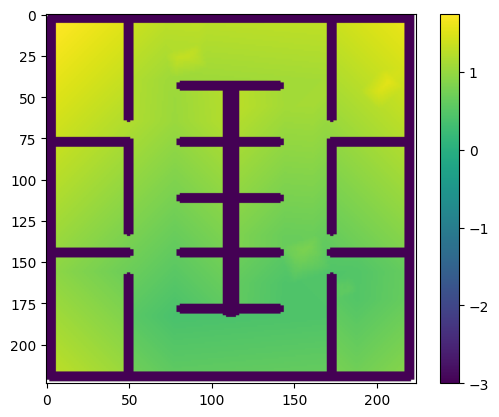

In [ ]:
robot_distance = np.load(all_datafiles[0])['robot_distance']
goal_distance = np.load(all_datafiles[0])['goal_distance']

robot_distance[robot_distance == -1] = -2

plt.imshow(robot_distance + goal_distance)
# plt.imshow(data['goal_distance'])
plt.colorbar()

In [ ]:
environment_performance['env_config_1375a.xml']

{'total_episodes': 7,
 'successful_episodes': 4,
 'timeout_episodes': 3,
 'crashed_episodes': 0,
 'trivial_episodes': 0,
 'search_times': [2651.5960693359375,
  7793.516159057617,
  7460.404872894287,
  4836.91143989563,
  2102.8411388397217,
  418.27964782714844,
  1135.4966163635254],
 'nodes_expanded': [5, 10, 10, 7, 4, 1, 2],
 'terminal_checks': [7, 11, 11, 9, 6, 3, 4]}

In [ ]:
hard_results = {}
hard_keys = ['4258b', '1329e', '4258a', '3354c', '3629a', '177e', '1393a', '3546c', '1793d', '1375a']
hard_success = 0
total_episodes = 0
for key in hard_keys:
    r = environment_performance[f"env_config_{key}.xml"]
    hard_results[key] = {}
    hard_results[key]['success_rate'] = r['successful_episodes'] / r['total_episodes']
    hard_success += r['successful_episodes']
    total_episodes += r['total_episodes']
    hard_results[key]['median_nodes_expanded'] = np.median(r['nodes_expanded'])
    hard_results[key]['median_terminal_checks'] = np.median(r['terminal_checks'])
    hard_results[key]['median_search_time'] = np.median(r['search_times'])


hard_success/total_episodes

0.4714285714285714

In [ ]:
medium_results = {}
medium_keys = ['1362b', '1362d', '1373e', '3452a', '1376d', '3624e', '1392c', '3311a', '3624d', '1392d']
medium_success = 0
total_episodes = 0

for key in medium_keys:
    r = environment_performance[f"env_config_{key}.xml"]
    medium_results[key] = {}
    medium_results[key]['success_rate'] = r['successful_episodes'] / r['total_episodes']
    medium_success += r['successful_episodes']
    total_episodes += r['total_episodes']
    medium_results[key]['median_nodes_expanded'] = np.median(r['nodes_expanded'])
    medium_results[key]['median_terminal_checks'] = np.median(r['terminal_checks'])
    medium_results[key]['median_search_time'] = np.median(r['search_times'])

medium_success/total_episodes

0.3142857142857143

In [ ]:
easy_results = {}
easy_keys = ['3327a', '3275a', '3498b', '1774d', '3937d', '3956a', '4164b', '399c', '1381c', '1376a']
easy_success = 0
total_episodes = 0

for key in easy_keys:
    r = environment_performance[f"env_config_{key}.xml"]
    easy_results[key] = {}
    easy_results[key]['success_rate'] = r['successful_episodes'] / r['total_episodes']
    easy_success += r['successful_episodes']
    total_episodes += r['total_episodes']
    easy_results[key]['median_nodes_expanded'] = np.median(r['nodes_expanded'])
    easy_results[key]['median_terminal_checks'] = np.median(r['terminal_checks'])
    easy_results[key]['median_search_time'] = np.median(r['search_times'])
    
easy_success/total_episodes

0.7142857142857143

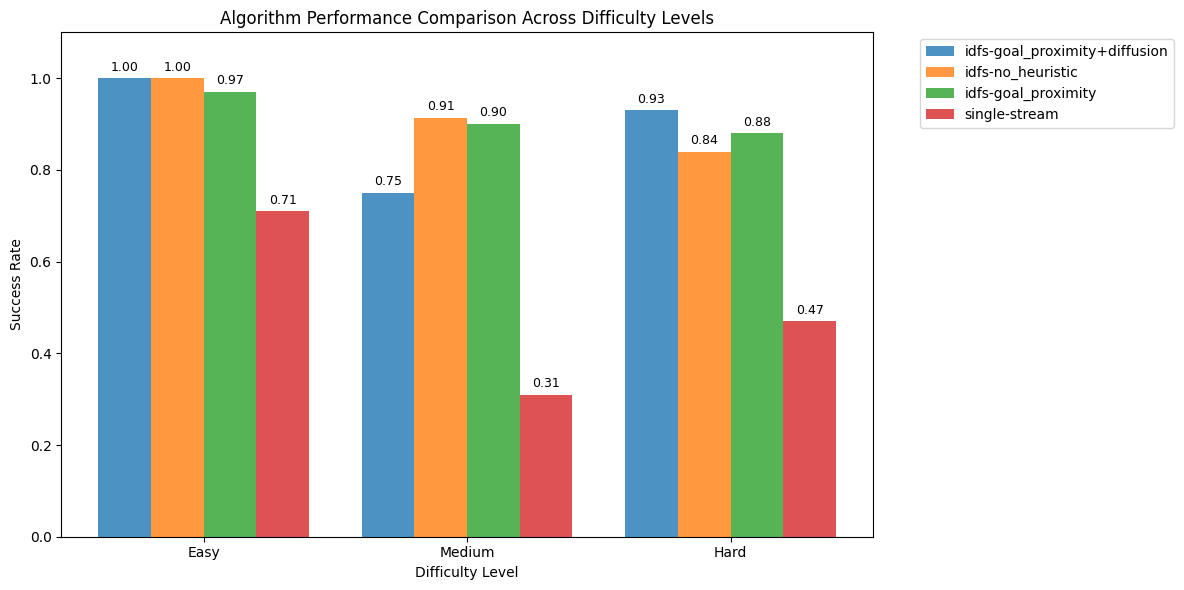

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for comparison
algorithms = ['idfs-goal_proximity+diffusion', 'idfs-no_heuristic', 'idfs-goal_proximity', 'single-stream']
difficulties = ['Easy', 'Medium', 'Hard']

# Reorganize data by difficulty level
easy_rates = [1.00, 1.00, 0.97, 0.71]
medium_rates = [0.75, 0.914, 0.90, 0.31]
hard_rates = [0.93, 0.84, 0.88, 0.47]

x = np.arange(len(difficulties))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5*width, [easy_rates[0], medium_rates[0], hard_rates[0]], width, label=algorithms[0], alpha=0.8)
bars2 = ax.bar(x - 0.5*width, [easy_rates[1], medium_rates[1], hard_rates[1]], width, label=algorithms[1], alpha=0.8)
bars3 = ax.bar(x + 0.5*width, [easy_rates[2], medium_rates[2], hard_rates[2]], width, label=algorithms[2], alpha=0.8)
bars4 = ax.bar(x + 1.5*width, [easy_rates[3], medium_rates[3], hard_rates[3]], width, label=algorithms[3], alpha=0.8)

ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Success Rate')
ax.set_title('Algorithm Performance Comparison Across Difficulty Levels')
ax.set_xticks(x)
ax.set_xticklabels(difficulties)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 1.1)

# Add value labels on bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# hard, medium, easy
# idfs-goal_proximity+diffusion: 93%, 75%, 100%
# idfs-no_heuristic: 84%, 91.4%, 100%
# idfs-goal_proximity: 88%, 90%, 97%
# single-stream: 47%, 31%, 71%

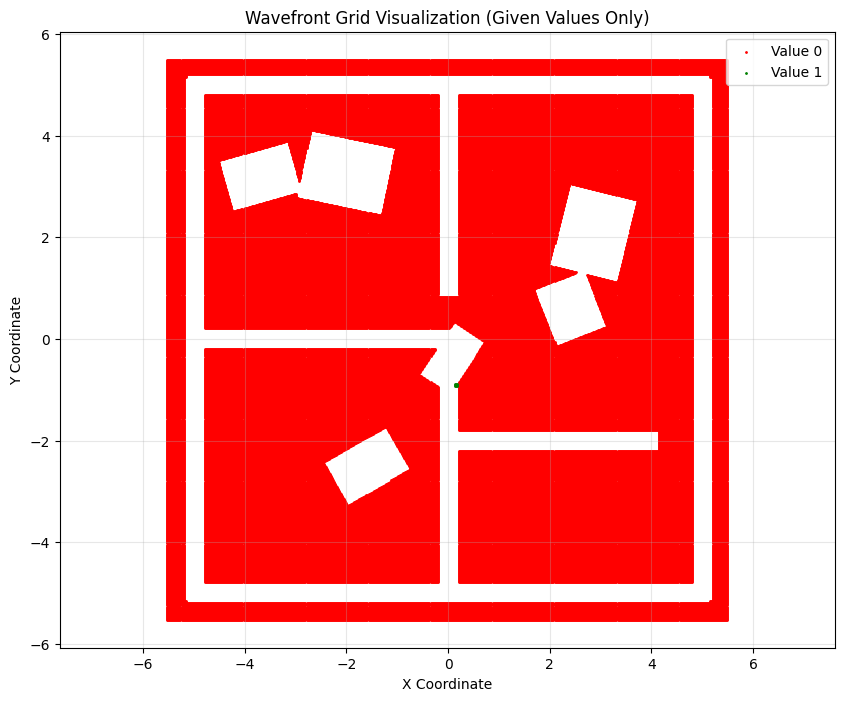

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the wavefront data
WAVEFRONT_FILE = "../mpc_wavefront_no_reachable_edges_iter_1.txt"
with open(WAVEFRONT_FILE, "r") as f:
    lines = f.readlines()

d = [] # [(x, y, value), ...]
for line in lines:
    if line.strip():  # Skip empty lines
        d.append([float(x) for x in line.split()])

# Convert to numpy array for easier plotting
d = np.array(d)

# Extract x, y, and values
x_coords = d[:, 0]
y_coords = d[:, 1]
values = d[:, 2]

# Define "given" values with specific colors
given_values = [0, 1, -3, -4]
colors = ['red', 'green', 'blue']  # Colors for each value respectively

# Create a scatter plot
plt.figure(figsize=(10, 8))

# Plot each value type with its specific color
for value, color in zip(given_values, colors):
    mask = values == value
    if np.any(mask):
        plt.scatter(x_coords[mask], y_coords[mask], c=color, s=1, label=f'Value {value}')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Wavefront Grid Visualization (Given Values Only)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()


In [8]:
with open(f"../test_envs/envs_names_very_hard.pkl", "rb") as f:
    env_names_very_hard = pickle.load(f)

env_names_very_hard

['easy/set1/benchmark_1/env_config_3624c.xml',
 'easy/set1/benchmark_2/env_config_3282c.xml',
 'easy/set1/benchmark_2/env_config_3282d.xml',
 'easy/set1/benchmark_5/env_config_5286b.xml',
 'easy/set1/benchmark_5/env_config_5286c.xml',
 'easy/set1/benchmark_5/env_config_5286e.xml',
 'easy/set1/benchmark_5/env_config_5313a.xml',
 'easy/set2/benchmark_2/env_config_1329e.xml',
 'easy/set2/benchmark_2/env_config_1334b.xml',
 'easy/set2/benchmark_2/env_config_1360b.xml',
 'easy/set2/benchmark_2/env_config_1360d.xml',
 'easy/set2/benchmark_2/env_config_1364d.xml',
 'easy/set2/benchmark_3/env_config_1372e.xml',
 'easy/set2/benchmark_3/env_config_1375d.xml',
 'easy/set2/benchmark_3/env_config_1381b.xml',
 'easy/set2/benchmark_3/env_config_1391e.xml',
 'easy/set2/benchmark_3/env_config_1393d.xml',
 'easy/set2/benchmark_5/env_config_1748c.xml',
 'easy/set2/benchmark_5/env_config_1748d.xml',
 'medium/set1/benchmark_1/env_config_2012c.xml',
 'medium/set1/benchmark_2/env_config_1917b.xml',
 'medium/

In [ ]:
# "medium/set1/benchmark_2/env_config_1960d.xml"
# 'medium/set1/benchmark_2/env_config_1917b.xml',
# 'medium/set1/benchmark_2/env_config_1917c.xml',
# 'medium/set1/benchmark_2/env_config_1917d.xml',
# 'medium/set1/benchmark_2/env_config_1960d.xml'
# 'medium/set1/benchmark_5/env_config_276a.xml',
# 'medium/set1/benchmark_5/env_config_278d.xml',
# 'medium/set2/benchmark_2/env_config_1216a.xml',
# 'medium/set2/benchmark_2/env_config_1216b.xml',
# 'medium/set2/benchmark_2/env_config_1216c.xml',
# 'medium/set2/benchmark_2/env_config_1216d.xml',
# 'medium/set2/benchmark_2/env_config_1216e.xml',
# 'medium/set2/benchmark_2/env_config_1218b.xml',
#  'medium/set2/benchmark_2/env_config_1218d.xml',
# 'medium/set2/benchmark_2/env_config_1220b.xml',

